# Neural Network Initialization Demo
## Introduction to Initialization
* I'm going to show you why weight initialization is critical in deep neural networks.

* We'll use a 50-layer network with 80 units per layer to see how different initializations affect activations and gradients.

* Watch for **vanishing gradients** (signals shrink to zero) and **exploding gradients** (signals grow uncontrollably).


# Step 1: Import Libraries and Define Activation Function

* First, we import NumPy for math and Matplotlib for plotting.

* We define the ReLU activation function, which clips negative values to zero, a key factor in our initialization strategy.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def ReLU(preactivation):
    return np.clip(preactivation, 0, None)

# Step 2: Initialize Network Parameters

* Here, we set up the network with 50 layers and 80 units per layer.

* We test three initialization methods:

  - **Uniform (σ²=10.0)**: High variance, likely to cause exploding gradients.

  - **Uniform (σ²=0.01)**: Low variance, likely to cause vanishing gradients.
  
  - **He Initialization**: Sets variance to 2/D (where D is layer size) to keep signals stable.

In [15]:
def init_params(K, D, sigma_sq_omega=None, init_method='uniform'):
    np.random.seed(0)
    D_i = 1  # Input dimension
    D_o = 1  # Output dimension
    all_weights = [None] * (K + 1)
    all_biases = [None] * (K + 1)
    
    if init_method == 'uniform':
        assert sigma_sq_omega is not None, "Provide sigma_sq_omega for uniform init"
        all_weights[0] = np.random.normal(size=(D, D_i)) * np.sqrt(sigma_sq_omega)
        all_weights[-1] = np.random.normal(size=(D_o, D)) * np.sqrt(sigma_sq_omega)
        for layer in range(1, K):
            all_weights[layer] = np.random.normal(size=(D, D)) * np.sqrt(sigma_sq_omega)
    elif init_method == 'he':
        all_weights[0] = np.random.normal(size=(D, D_i)) * np.sqrt(2 / D_i)
        for layer in range(1, K):
            all_weights[layer] = np.random.normal(size=(D, D)) * np.sqrt(2 / D)
        all_weights[-1] = np.random.normal(size=(D_o, D)) * np.sqrt(2 / D)
    
    for layer in range(K + 1):
        all_biases[layer] = np.zeros((D if layer < K else D_o, 1))
    
    return all_weights, all_biases

# Step 3: Forward Pass Computation

* This function computes the network’s output by passing input through 50 layers.

* We store activations (all_h) to analyze their variance later.

* Let’s see how initialization affects the signal as it moves forward.

In [16]:
def compute_network_output(net_input, all_weights, all_biases):
    K = len(all_weights) - 1
    all_f = [None] * (K + 1)
    all_h = [None] * (K + 1)
    all_h[0] = net_input
    for layer in range(K):
        all_f[layer] = all_biases[layer] + np.matmul(all_weights[layer], all_h[layer])
        all_h[layer + 1] = ReLU(all_f[layer])
    all_f[K] = all_biases[K] + np.matmul(all_weights[K], all_h[K])
    return all_f[K], all_f, all_h

# Step 4: Loss and Backward Pass
* We use a simple least squares loss to measure error.

* The backward pass computes gradients, which we’ll analyze to see if they vanish or explode.

* These functions are key to understanding how initialization affects training.

In [17]:
def least_squares_loss(net_output, y):
    return np.sum((net_output - y) ** 2)

def d_loss_d_output(net_output, y):
    return 2 * (net_output - y)

def backward_pass(all_weights, all_biases, all_f, all_h, y):
    K = len(all_weights) - 1
    all_dl_df = [None] * (K + 1)
    all_dl_df[K] = d_loss_d_output(all_f[K], y)
    all_dl_dweights = [None] * (K + 1)
    all_dl_dbiases = [None] * (K + 1)
    
    for layer in range(K, -1, -1):
        all_dl_dbiases[layer] = all_dl_df[layer]
        all_dl_dweights[layer] = np.matmul(all_dl_df[layer], all_h[layer].T)
        if layer > 0:
            all_dl_df[layer - 1] = (all_f[layer - 1] > 0).astype(float) * np.matmul(all_weights[layer].T, all_dl_df[layer])
    
    return all_dl_dweights, all_dl_dbiases, all_dl_df

# Step 5: Run Forward Pass Demo
* Now, let’s run the forward pass with 1000 input samples.

* We’ll plot the standard deviation of activations across layers on a log scale.

* Watch how σ²=10.0 explodes, σ²=0.01 vanishes, and He stays stable.

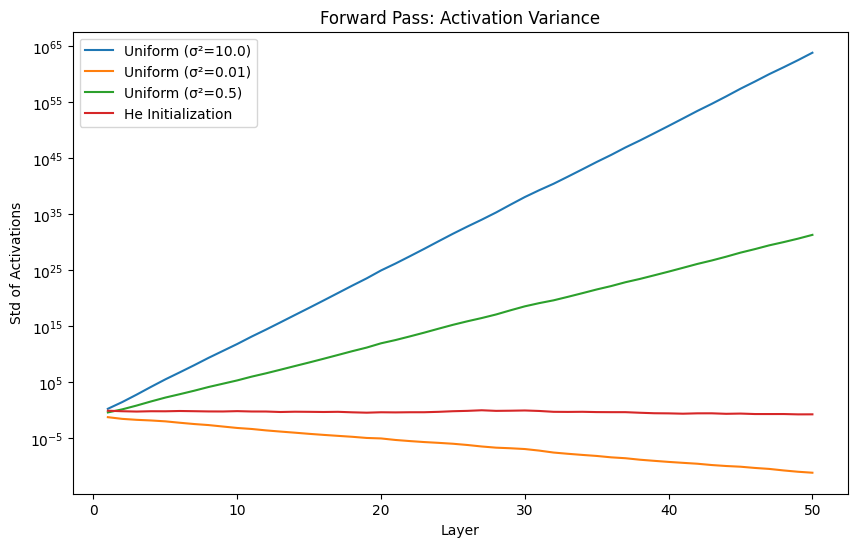

In [18]:
K = 50  # 50 layers
D = 80  # 80 units per layer
n_data_forward = 1000

init_methods = [
    ('Uniform (σ²=10.0)', {'sigma_sq_omega': 10.0, 'init_method': 'uniform'}),
    ('Uniform (σ²=0.01)', {'sigma_sq_omega': 0.01, 'init_method': 'uniform'}),
    ('Uniform (σ²=0.5)', {'sigma_sq_omega': 0.5, 'init_method': 'uniform'}),
    ('He Initialization', {'init_method': 'he'})
]

plt.figure(figsize=(10, 6))
data_in = np.random.normal(size=(1, n_data_forward))
for name, params in init_methods:
    all_weights, all_biases = init_params(K, D, **params)
    _, _, all_h = compute_network_output(data_in, all_weights, all_biases)
    std_h = [np.std(all_h[layer].ravel()) for layer in range(1, K + 1)]
    plt.plot(range(1, K + 1), std_h, label=name)
plt.xlabel('Layer')
plt.ylabel('Std of Activations')
plt.title('Forward Pass: Activation Variance')
plt.yscale('log')
plt.legend()
plt.show()

# Step 6: Run Backward Pass Demo
* Finally, we run the backward pass with 100 samples to compute gradients.

* The plot shows gradient variance across layers.

* Notice the same pattern: exploding with high variance, vanishing with low, and stable with He.

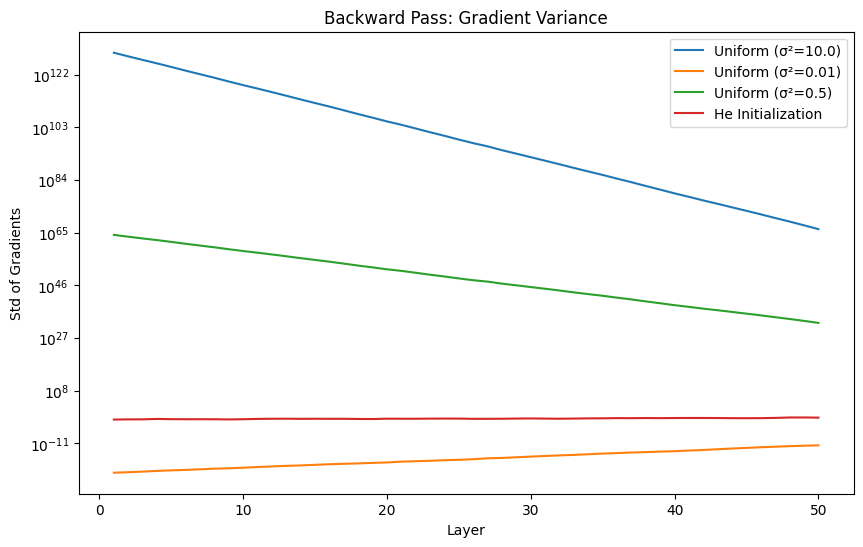

In [19]:
n_data_backward = 100
plt.figure(figsize=(10, 6))
for name, params in init_methods:
    all_weights, all_biases = init_params(K, D, **params)
    aggregate_dl_df = [np.zeros((D, n_data_backward)) for _ in range(K)]
    for i in range(n_data_backward):
        data_in = np.random.normal(size=(1, 1))
        y = np.zeros((1, 1))
        net_output, all_f, all_h = compute_network_output(data_in, all_weights, all_biases)
        all_dl_dweights, all_dl_dbiases, all_dl_df = backward_pass(all_weights, all_biases, all_f, all_h, y)
        for layer in range(K):
            aggregate_dl_df[layer][:, i] = np.squeeze(all_dl_df[layer])
    std_dl_df = [np.std(agg.ravel()) for agg in aggregate_dl_df]
    plt.plot(range(1, K + 1), std_dl_df, label=name)
plt.xlabel('Layer')
plt.ylabel('Std of Gradients')
plt.title('Backward Pass: Gradient Variance')
plt.yscale('log')
plt.legend()
plt.show()

# Conclusion
* This demo shows why initialization matters.

* Poor choices like σ²=10.0 cause explosions, σ²=0.01 causes vanishing signals.

* He initialization keeps both activations and gradients stable, enabling effective training.

* That’s why we use methods like He in deep learning.